$$
p(r) =
\begin{cases}
−k_1(r − 2l) & \text{ if } r < 2l,\\
−k_2(r − 2l) & \text{ if } r ≥ 2l
\end{cases}
$$

$$
j(u, v) = −p(\theta(u))\theta(v)
\qquad \forall u = (u_1, u_2), v = (v_1, v_2) \in V
$$

$$
\int_a^{-l} \sigma_1 (\frac{d v_1}{d x} - \frac{d u_1}{d x}) dx + \int_l^b \sigma_2 (\frac{d v_2}{d x} - \frac{d u_2}{d x}) dx - j(u, v) + j(u, u) \geq (f, v-u)_V \quad \forall v \in K
$$

$$
\int_a^{-l} \alpha_1 \frac{d u_1}{d x}  (\frac{d v_1}{d x} - \frac{d u_1}{d x}) dx + \int_l^b \alpha_2 \frac{d u_2}{d x} (\frac{d v_2}{d x} - \frac{d u_2}{d x}) dx + p(\theta(u))\theta(v) −p(\theta(u))\theta(u) \geq (f, v-u)_V \quad \forall v \in K
$$
Assuming the spring is compressed, we have
$$
\int_a^{-l} \alpha_1 \frac{d u_1}{d x}  (\frac{d v_1}{d x} - \frac{d u_1}{d x}) dx + \int_l^b \alpha_2 \frac{d u_2}{d x} (\frac{d v_2}{d x} - \frac{d u_2}{d x}) dx + k_1(\theta(u) − 2l)(\theta(u) - \theta(v)) \geq (f, v-u)_V \quad \forall v \in K
$$

Minimization problem
$$
\underset{u \in V}{min}: J(u) = \frac{1}{2}(Au, u) + j(u) - (f,u)
$$
with
$$
\begin{cases}
(Au,v) = \int_a^{-l} \mathcal{F}_1(\frac{du_1}{dx})\frac{dv_1}{dx}dx + \int_l^b \mathcal{F}_2(\frac{du_2}{dx})\frac{dv_2}{dx}dx \\
j(u) = -k_1 \frac{(\theta(u)-2l)^2}{2}\\
(f, u) = \int_a^{-l} f_1 u_1 dx + \int_l^b f_2 u_2 dx
\end{cases}
$$

In [1]:
from typing import Tuple, Callable, Union
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
class SprintRodsSystemSetup:

    def __init__(
            self,
            interval: Tuple[float, float],
            spring_len: float,
            nodes_num: int,
            material_const: Tuple[float, float],
            spring_const: Tuple[float, float],
            body_forces: Callable[[np.ndarray], Union[np.ndarray, float]]
    ):
        self.left_end, self.right_end = interval
        self.spring_len = spring_len
        self.half_spring_len = spring_len / 2
        self.nodes_num = nodes_num
        self.body_forces = body_forces

        self.left_domain = np.linspace(self.left_end, -self.half_spring_len, nodes_num)
        self.right_domain = np.linspace(self.half_spring_len, self.right_end, nodes_num)
        self.alphas = material_const
        self.spring_const = spring_const

    def __call__(self, displacements: np.ndarray):
        return self.A(displacements) / 2 + self.j(displacements) - self.f(displacements)

    def set_material_const(self, material_const: Tuple[float, float]):
        self.alphas = material_const

    def set_spring_const(self, spring_const: Tuple[float, float]):
        self.spring_const = spring_const

    def A(self, displacements: np.ndarray):
        left_displ = displacements[:self.nodes_num]
        right_displ = displacements[self.nodes_num:]

        left = np.diff(left_displ) ** 2 / np.diff(self.left_domain)
        right = np.diff(right_displ) ** 2 / np.diff(self.right_domain)

        return self.alphas[0] * np.sum(left) + self.alphas[1] * np.sum(right)

    def j(self, displacements: np.ndarray):
        left_end_displ = displacements[self.nodes_num - 1]
        right_end_displ = displacements[self.nodes_num]
        const = self.spring_const[0 if right_end_displ - left_end_displ < 0 else 1]
        return const * (right_end_displ - left_end_displ) ** 2 / 2

    def f(self, displacements: np.ndarray):
        fun_vals = self.compute_body_forces()

        left_displ = displacements[:self.nodes_num]
        right_displ = displacements[self.nodes_num:]

        left = np.diff(self.left_domain) * (left_displ[1:] + left_displ[:-1]) / 2
        right = np.diff(self.right_domain) * (right_displ[1:] + right_displ[:-1]) / 2

        return np.sum(fun_vals * np.concatenate((left, right)))

    def compute_body_forces(self):
        left_centers = (self.left_domain[1:] + self.left_domain[:-1]) / 2
        right_centers = (self.right_domain[1:] + self.right_domain[:-1]) / 2
        centers = np.concatenate((left_centers, right_centers))
        return self.body_forces(centers)

In [3]:
model = SprintRodsSystemSetup(
    interval=(-1, 1),
    spring_len=1,
    nodes_num=10,
    material_const=(1, 1),
    spring_const=(1, 1),
    body_forces=lambda x: 1.
)

In [4]:
constraint = np.zeros(2 * model.nodes_num)
constraint[model.nodes_num - 1] = 1
constraint[model.nodes_num] = -1

prevent_penetration = optimize.LinearConstraint(A=constraint, lb=-np.inf, ub=model.spring_len)

In [5]:
lower_bounds = np.full(2 * model.nodes_num, fill_value=-np.inf)
lower_bounds[0] = 0
lower_bounds[-1] = 0

upper_bounds = np.full(2 * model.nodes_num, fill_value=np.inf)
upper_bounds[0] = 0
upper_bounds[-1] = 0

dirichlet_boundaries = optimize.Bounds(lower_bounds, upper_bounds)

In [6]:
result = optimize.minimize(fun=model, x0=np.zeros(2 * model.nodes_num), constraints=prevent_penetration, bounds=dirichlet_boundaries)
displacements = result.x

assert result.success
result

     fun: -0.04153806584323905
     jac: array([-4.99998227e-01, -3.05473804e-07, -4.56348062e-08,  3.11993062e-07,
        6.35161996e-07, -1.69035047e-07, -4.14904207e-07,  2.12341547e-07,
        1.33179128e-07,  2.99420208e-07,  2.99885869e-07,  1.33644789e-07,
        2.13272870e-07, -4.13507223e-07, -1.69500709e-07,  6.33299351e-07,
        3.11061740e-07, -4.65661287e-08, -3.07336450e-07, -4.99998228e-01])
 message: 'Optimization terminated successfully.'
    nfev: 236
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.        , 0.02623448, 0.04938257, 0.06944425, 0.08641952,
       0.10030834, 0.11111077, 0.11882682, 0.12345645, 0.12499967,
       0.12499967, 0.12345645, 0.11882682, 0.11111077, 0.10030834,
       0.08641952, 0.06944425, 0.04938257, 0.02623448, 0.        ])

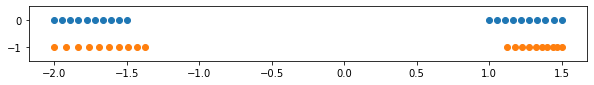

In [7]:
positions = np.concatenate((
    model.left_end + model.left_domain,
    model.half_spring_len + model.right_domain
))

fig = plt.gcf()
fig.set_size_inches(10, 1)
plt.ylim(-1.5, 0.5)
plt.scatter(x=positions, y=np.zeros(2 * model.nodes_num))
plt.scatter(x=positions + displacements, y=np.full(2 * model.nodes_num, fill_value=-1))

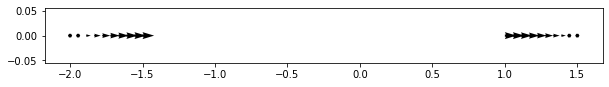

In [8]:
fig = plt.gcf()
fig.set_size_inches(10, 1)
plt.quiver(positions, np.zeros_like(positions), displacements, np.zeros_like(displacements), scale=6)